# Práctica 10: Clasificación de datos con sklearn.

El término clasificación hace referencia a la asignación automática de datos en grupos previamente conocidos de acuerdo a sus atributos. En el caso estudiado para los datos que se presentan en esta práctica, los dos grupos de interés son el conjunto benigno y maligno de datos, de donde se han explorado diferentes métodos para separar sus características de manera que permita hacer una clasificación con exactitud buena.



In [8]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan, arange, meshgrid, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis



El primer paso es cargar los datos del CSV. Se sigue con el procedimiento utilizado en prácticas anteriores y se re escriben los datos de M y B con 0 y 1 como las etiquetas deseadas de salida.

Después, para poder tener una idea de cómo se separan los datos del clasificador, se toman los máximos de los valores de radius_mean y radius_worst en los valores de diagnostico benignos, con la idea de que cualquier elemento que se encuentre por encima de esos valores, tiene que ser maligno.

Esto surge con la idea que en prácticas anteriores, utilizando los valores de parámetros con menos relación se podía lograr una clasificación más exacta. Una de las conclusiones sacadas anteriormente fue que el 'cluster' que se notaba en gráficas de clasificaciones anteriores podría deshacerse si se utilizan las características de cada columna del csv.

En este caso se tiene la idea de que el máximo de los benignos y el mínimo de los malignos son valores en donde se encuentra el 'cluster' mencionado, por lo que en esta práctica se buscará deshacer esto utilizando los máximos y mínimos de varias columnas. El 'radius_mean' y el 'radius_worst' son los dos datos en los que se puede hacer un umbral similar.


In [9]:
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv("https://raw.githubusercontent.com/mayraberrones94/Ciencia_de_Datos/master/bp_w-data.csv")
d.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

m = d.loc[d.diagnosis == 1]
b = d.loc[d.diagnosis == 0]
print(m.radius_mean.max(), m.radius_worst.max())
print(m.radius_mean.min(), m.radius_worst.min())
print(b.radius_mean.max(), b.radius_worst.max())
print(b.radius_mean.min(), b.radius_worst.min())



28.11 36.04
10.95 12.84
17.85 19.82
6.981 7.93




Estos dos valores se colocan en los valores de las etiquetas con las que se va a realizar el clasificador. En el primer intento de corrida, el programa marca error porque hacia falta el valor h en el código. Después de revisar el código en el link proporcionado en la práctica de ejemplo, se ve que el valor de la h se utiliza como parámetro de tamaño del paso que se va a dar en la parte de entrenamiento y prueba. Se toma el mismo valor ahí mencionado, 0.02.



0    441
1     98
2     30
Name: etiquetas, dtype: int64


/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.13121889,  1.95281997]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


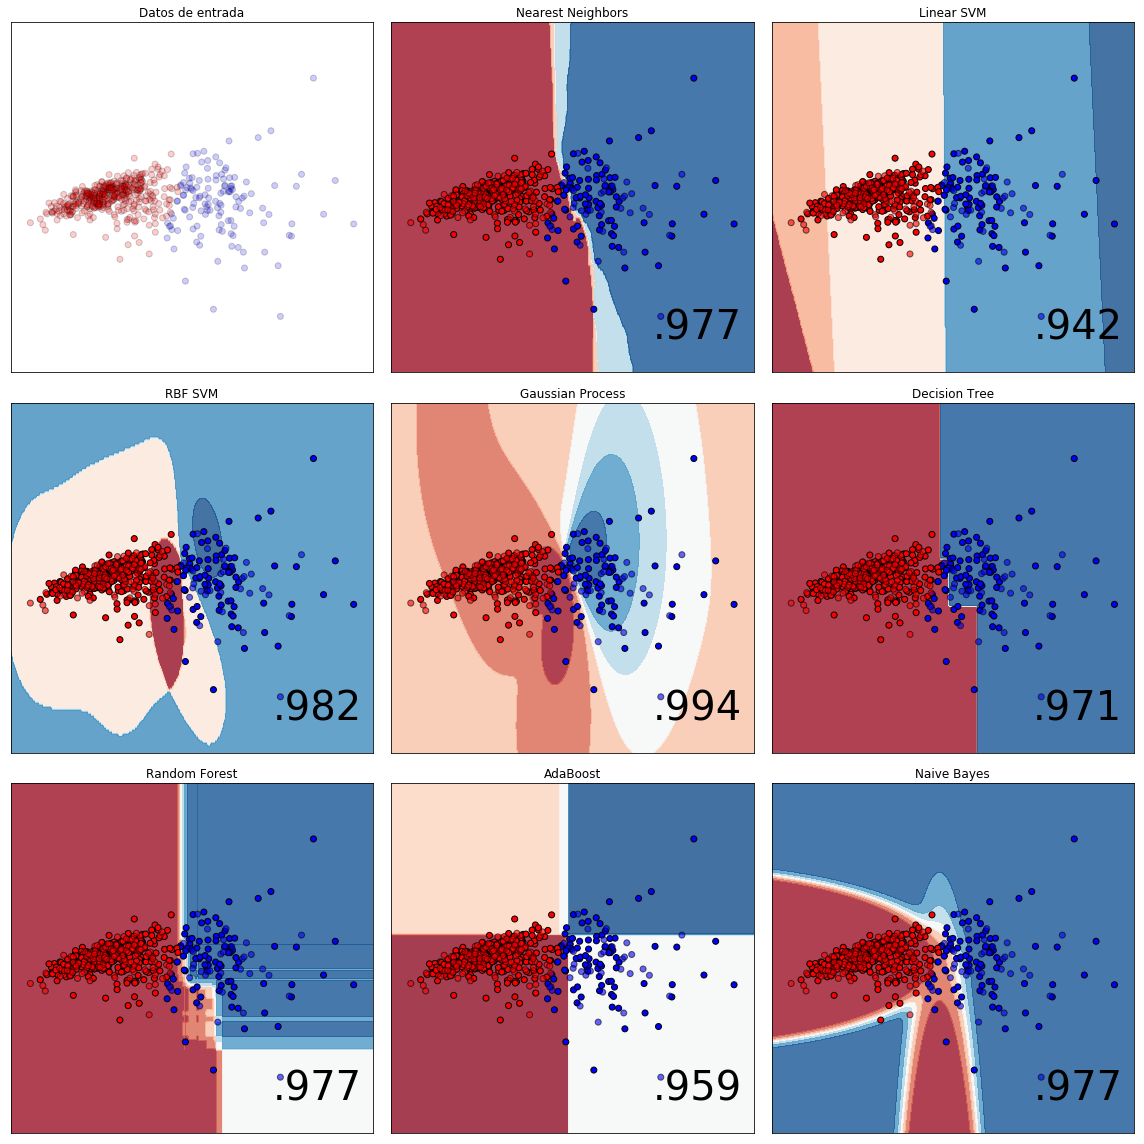

In [10]:
pri = d.radius_mean >= 17.85
seg = d.radius_worst >= 19.82
ter = ~pri & ~seg

d['etiquetas'] = [1 if  pri[i] else (2 if seg[i] else (0 if ter[i] else "NA")) for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['radius_mean', 'radius_worst']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)
# código de https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
h = .02  # step size in the mesh
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
k = int(ceil(sqrt(len(classifiers) + 1)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42) # división
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = meshgrid(arange(x_min, x_max, h), arange(y_min, y_max, 0.02))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.rcParams["figure.figsize"] = [16, 16]
figure = plt.figure()
ax = plt.subplot(k, k, 1)
ax.set_title("Datos de entrada")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.2, edgecolors='k') # entrenamiento
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.2, edgecolors='k') # validación
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = 2
for name, clf in zip(names, classifiers):
    ax = plt.subplot(k, k, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'), size=40, horizontalalignment='right')
    i += 1
plt.tight_layout()
plt.show()



Como resultado en las gráficas se tiene una buena separación de los datos y una alta exactitud de clasificación en todos los clasificadores. El siguiente paso es saber la precisión, el “recall” y el “F1-score”, que son las mediciones utilizadas para reportar el rendimiento de una herramienta de aprendizaje de máquina. 




In [12]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42) # la misma división
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name, clf.score(X_test, y_test))
    expected, predicted = y_test, clf.predict(X_test)
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print('-' * 60)


Nearest Neighbors 0.9766081871345029
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       133
           1       0.93      1.00      0.97        28
           2       0.88      0.70      0.78        10

   micro avg       0.98      0.98      0.98       171
   macro avg       0.93      0.90      0.91       171
weighted avg       0.98      0.98      0.98       171

[[132   0   1]
 [  0  28   0]
 [  1   2   7]]
------------------------------------------------------------
Linear SVM 0.9415204678362573
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       133
           1       0.85      1.00      0.92        28
           2       0.00      0.00      0.00        10

   micro avg       0.94      0.94      0.94       171
   macro avg       0.60      0.67      0.63       171
weighted avg       0.89      0.94      0.91       171

[[133   0   0]
 [  0  28   0]
 [  5   5   0]]
------------------

/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.13121889,  1.95281997]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


Gaussian Process 0.9941520467836257
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       133
           1       1.00      1.00      1.00        28
           2       0.91      1.00      0.95        10

   micro avg       0.99      0.99      0.99       171
   macro avg       0.97      1.00      0.98       171
weighted avg       0.99      0.99      0.99       171

[[132   0   1]
 [  0  28   0]
 [  0   0  10]]
------------------------------------------------------------
Decision Tree 0.9707602339181286
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       133
           1       0.90      1.00      0.95        28
           2       0.78      0.70      0.74        10

   micro avg       0.97      0.97      0.97       171
   macro avg       0.89      0.89      0.89       171
weighted avg       0.97      0.97      0.97       171

[[131   0   2]
 [  0  28   0]
 [  0   3   7]]
----------------



Se repite el procedimiento con solo un dato, que es el “radius_mean” y se aumenta el valor del conjunto de prueba de 0.3 a 0.4. Los resultados tanto en las gráficas como en la parte de tablas de confusión mejoran.



0    471
1     98
Name: etiquetas, dtype: int64


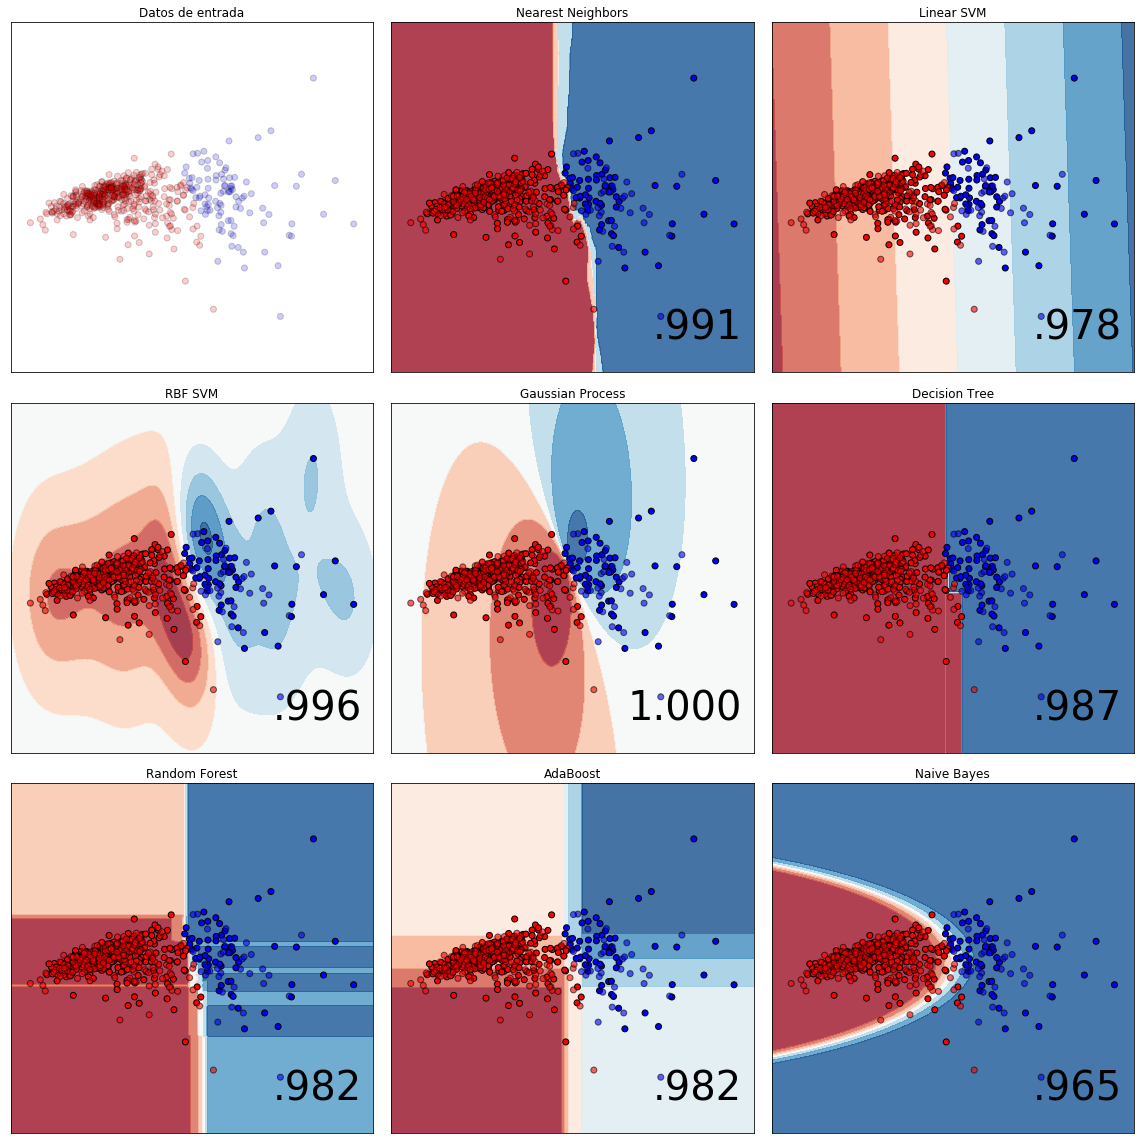

In [16]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan, arange, meshgrid, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
                                                 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv("https://raw.githubusercontent.com/mayraberrones94/Ciencia_de_Datos/master/bp_w-data.csv")
d.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

pri = d.radius_mean >= 17.85

d['etiquetas'] = [1 if  pri[i] else 0 for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['radius_mean', 'radius_worst']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)

h = .02  # step size in the mesh
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
k = int(ceil(sqrt(len(classifiers) + 1)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42) # división
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = meshgrid(arange(x_min, x_max, h), arange(y_min, y_max, 0.02))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.rcParams["figure.figsize"] = [16, 16]
figure = plt.figure()
ax = plt.subplot(k, k, 1)
ax.set_title("Datos de entrada")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.2, edgecolors='k') # entrenamiento
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.2, edgecolors='k') # validación
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = 2
for name, clf in zip(names, classifiers):
    ax = plt.subplot(k, k, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'), size=40, horizontalalignment='right')
    i += 1
plt.tight_layout()
plt.show()

In [17]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv("https://raw.githubusercontent.com/mayraberrones94/Ciencia_de_Datos/master/bp_w-data.csv")
d.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

pri = d.radius_mean >= 17.85

d['etiquetas'] = [1 if  pri[i] else 0 for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['radius_mean', 'radius_worst']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)
# código de https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42) # la misma división
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name, clf.score(X_test, y_test))
    expected, predicted = y_test, clf.predict(X_test)
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print('-' * 60)

0    471
1     98
Name: etiquetas, dtype: int64
Nearest Neighbors 0.9912280701754386
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       193
           1       0.95      1.00      0.97        35

   micro avg       0.99      0.99      0.99       228
   macro avg       0.97      0.99      0.98       228
weighted avg       0.99      0.99      0.99       228

[[191   2]
 [  0  35]]
------------------------------------------------------------
Linear SVM 0.9780701754385965
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       193
           1       0.88      1.00      0.93        35

   micro avg       0.98      0.98      0.98       228
   macro avg       0.94      0.99      0.96       228
weighted avg       0.98      0.98      0.98       228

[[188   5]
 [  0  35]]
------------------------------------------------------------
RBF SVM 0.9956140350877193
              precision    recall  f

Ahora que ya se tiene un buen resultado, se intenta poner más datos de los dos que se tomaron inicialmente. En la práctica de prueba de la Dra. Elisa, esto es con la intención de que salgan más alumnos que reprobaron en primera oportunidad. En el caso de esta práctica, la cantidad de casos malignos es más pequeña que la de los benignos por casi la mitad, por lo que un conjunto de datos de prueba más grande permitirá que tenga más posibilidad de tener datos balanceados.

In [18]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
d = pd.read_csv("https://raw.githubusercontent.com/mayraberrones94/Ciencia_de_Datos/master/bp_w-data.csv")
d.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

xv = ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', \
        'concavity_mean', 'radius_worst', 'texture_worst', 'perimeter_worst', \
        'area_worst', 'compactness_worst']
d = d.loc[:, xv]
for c in ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', \
        'concavity_mean', 'radius_worst', 'texture_worst', 'perimeter_worst', \
        'area_worst', 'compactness_worst']:
    cat = pd.Categorical(d[c])
    d[c] = cat.codes
d = d.dropna() 
d['etiqueta'] = d.diagnosis == 1
y = d.etiqueta
print(y.value_counts())
d = d.drop(['etiqueta'], 1)  
X = StandardScaler().fit_transform(d.values) # ahora SIN ejecutar PCA antes
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5) # cada ejecución tiene una división al azar
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_m = clf.predict(X_test)
    print(name, metrics.classification_report(y_test, y_m))
    print(metrics.confusion_matrix(y_test, y_m))
    print('-' * 60)

False    357
True     212
Name: etiqueta, dtype: int64
Nearest Neighbors               precision    recall  f1-score   support

       False       1.00      1.00      1.00       174
        True       1.00      1.00      1.00       111

   micro avg       1.00      1.00      1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

[[174   0]
 [  0 111]]
------------------------------------------------------------
Linear SVM               precision    recall  f1-score   support

       False       1.00      1.00      1.00       174
        True       1.00      1.00      1.00       111

   micro avg       1.00      1.00      1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

[[174   0]
 [  0 111]]
------------------------------------------------------------
RBF SVM               precision    recall  f1-score   support

       False       0.84      1.

/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mayraberrones/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Gaussian Process               precision    recall  f1-score   support

       False       1.00      1.00      1.00       174
        True       1.00      1.00      1.00       111

   micro avg       1.00      1.00      1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

[[174   0]
 [  0 111]]
------------------------------------------------------------
Decision Tree               precision    recall  f1-score   support

       False       1.00      1.00      1.00       174
        True       1.00      1.00      1.00       111

   micro avg       1.00      1.00      1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285

[[174   0]
 [  0 111]]
------------------------------------------------------------
Random Forest               precision    recall  f1-score   support

       False       0.97      0.97      0.97       174
        True       0.95 

Como se puede apreciar, el desempeño mejora en todos los casos, algunos alcanzando una clasificación perfecta. En el primer experimento tanto como en el segundo se pueden apreciar aún algunos datos que se intersectan y que resulta difícil clasificarlos en dos clases separadas, pero es un margen mucho más pequeño de los que se notaban en prácticas anteriores, lo cual es un buen avance. 

Con los resultados de estos clasificadores se culmple uno de los objetivos que se tenían desde la primer práctica con estos datos, que era el de utilizar los valores máximos y mínimos por separado de los valores de diagnóstico malignos y benignos, resultando en un clasificador que permita separlos y clasificarlos.